# Importance Sampling, Sequential Importance Sampling and Particle Filters
Matthias, Yves, Leo and I, we recently discussed above sampling algorithms in the context of `monad-bayes`. To get a better understanding, I decided to implement them in Python.

## Importance sampling
... is a very general sampling method. For once, it has nothing to do with Markov chains and not even with Monte Carlo. 
Let's say you want to calculate the expectation of a function $f(x)$ w.r.t. a probability distribution $p(x)$. It is given by the following integral:
\begin{equation}
    \langle f \rangle_{p} = \int \mathrm d x \ f(x) p(x)
\end{equation}
Now in general, you might not be able to calculate this analytically, so you resort to numerics. If you could sample correctly from $p(x)$, you could draw $N$ samples $x_1, \ldots, x_N$ and approximate the integral by a sum:
\begin{equation}
    \langle f \rangle_{p} \approx \frac{1}{N} \sum_{i=1}^N f(x_i) p(x_i)
\end{equation}
The world unfortunately sometimes is kind of a bad place and sampling from $p(x)$ might not be possible. But you might be able to sample from a different distribution $q(x)$. Then, doing what physicists have been doing all their lifes, you insert a 1 and write:
\begin{align}
   \langle f \rangle_{p} &= \int \mathrm d x \ f(x) \frac{p(x)}{q(x)}q(x) \\
           &= \int \mathrm d x \ f(x) w(x) q(x) \\
           &= \langle f\cdot w \rangle_q
\end{align}

Here, we introduced the *importance weight* $w(x)=\frac{p(x)}{q(x)}$ and we see that we're now calculating the expectation value of a different functon w.r.t. a different distribution. That expectation value can now be again approximated, supposed we draw $N$ samples $x_1, \ldots, x_N$ from $q$ (confusing, right?):
\begin{equation}
    \langle f \rangle_p = \langle f\cdot w \rangle_q \approx \frac{1}{N}\sum_{i=1}^N f(x_i) w(x_i)
\end{equation}
TODO: I'm not clear why we have to normalize the importants weights (which I haven't done here, but later in the code I do)

Voili, voilà&mdash;this is called *importance sampling*, because instead from $p$, we sample from an *importance distribution* $q$. Now you see a problem here: if the distributions $p$ and $q$ don't match up well (and in general, they won't), you will draw many samples from $q$ which have low importance weights $w(x_i)$ and thus contribute only little to the approximation, meaning you will need a lot of samples and still might get a bad estimate.

### Implementing importance sampling
Let's first import useful stuff and define a few PDFs:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
choice = np.random.choice


class Pdf(object):

    def __call__(self, x):
        """log-probability"""
        pass

    def sample(self, n):
        pass



class Gaussian(Pdf):

    def __init__(self, mu=0, sigma=1):

        self.mu = mu
        self.sigma = sigma

    def __call__(self, x):

        return -0.5 * (x - self.mu) ** 2 / self.sigma / self.sigma

    def sample(self, n):

        return np.random.normal(self.mu, self.sigma, n)


class Uniform(Pdf):

    def __init__(self, low, high):

        self.low = low
        self.high = high

    def __call__(self, x):

        return np.repeat(-np.log(self.high - self.low), len(x))

    def sample(self, n):

        return np.random.uniform(self.low, self.high, n)

Now we whip up a class implementing Importance Sampling. Its `sample` method will return the samples from the importance distribution and the corresponding importance weights. Also, as you might have noticed, we work in log-space for numeric stability.

In [2]:
class ImportanceSampler(object):

    def __init__(self, posterior):

        self.posterior = posterior

    def sample(self, imp_dist, n_samples):

        imp_samples = imp_dist.sample(n_samples)
        imp_weights = self.calculate_weights(imp_dist, imp_samples)
        # doing stuff in log-space to avoid underflows
        normalized_imp_weights = imp_weights - logsumexp(imp_weights)

        return imp_samples, normalized_imp_weights

    def calculate_weights(self, imp_dist, imp_samples):

        return self.posterior(imp_samples) - imp_dist(imp_samples)
    

Let's try this out. We want to sample from a Gaussian distribution, but we pretend we cannot, so we sample from a uniform importance distribution instead:

In [3]:
n_samples = 200000
target = Gaussian()
imp = Uniform(-10, 10)
sampler = ImportanceSampler(target)
biased_samples, logws = sampler.sample(imp, n_samples)

Now I've been talking a lot about approximating expectation values, but for personal reasons, I'm actually more interested in the actual samples. So how do you get samples from the target distribution from the importance samples and their weights? Well, you just draw from the set of importance samples, but with probabilities given by the importance weights:

In [4]:
samples = choice(biased_samples, n_samples, p=np.exp(logws))

Gesagt, getan, so now we can plot a histogram of the actual (unbiased) samples:

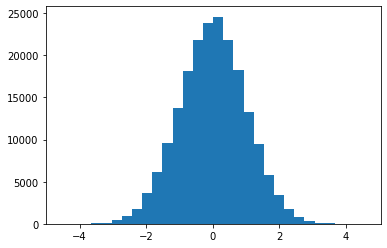

In [5]:
fig, ax = plt.subplots()
ax.hist(samples, bins=30)
plt.show()

So that's good: looks pretty normal to me.

## Sequential Importance Sampling
Now imagine we are dealing with a problem in which data is sequential, like a time series or a linear sequence of nucleotides in DNA. Let's assume that after $n$ (time) steps, you have $n$ observations $y_1, \ldots, y_n \equiv y_{1:n}$ and you want to know which parameters $x_1, \ldots, x_n\equiv x_{1:n}$ at steps $1, \ldots, n$ gave rise to these observations. Then you would have to draw samples from the posterior distribution $p(x_{1:n}|y_{1:n})$ of "paths" $x_{1:n}$. Say you somehow managed to do that and proceed to step $n+1$. Then you will have to sample from the posterior distributions of paths $x_{1:n+1}$. This gets pretty unwieldy for long sequences. 
But if you can assume that the sequence of $x$'ses is a Markov chain, namely, $p(x_{n+1}|x_{1:n}) = p(x_{n+1}|x_n)$, then you can recycle samples from previous time steps.
When using Importance Sampling to sample from these distributions, the importance weights can be calculated recursively. A nice special case is obtained if the importance distribution $q$ is just the prior distribution $p(x_{1:n})$. In that case, the importance weight of the $i$-th sample is given by
\begin{equation}
    w(x^i_n) \propto w(x^i_{n-1}) p(y_n|x^i_n)
\end{equation}

A problem with SIS is now that, after already a few steps, only very few weights will have values significantly different from zero. TODO: why exactly is that? I suspect that somehow the weights keep the memory of the initial stage when there was only very little data and the probabilities $p(y|x)$ are very low becaues of bad estimates of the $x$.

So let's implement SIS. First, we write a class representing a "sequential prior distribution", which encodes the Markov property. Basically, it draws new samples based only on the most recent batch of samples:

In [6]:
class SequentialPrior(Pdf):

    def __init__(self, distribution, first_state):

        self.distribution = distribution
        self.samples = first_state

    def sample(self, _):

        self.samples = self.distribution.sample(self.samples)

        return self.samples

To instantiate a `SequentialPrior` object, we require some conditional distribution (`distribution`) and an initial batch of samples (`first_state`). The `sample` method then draws samples from the distribution conditioned on the previous batch of samples.

Next up is the actual Sequential Importance Sampler. It derives from `ImportanceSampler`, but saves the current weights and modifies the `calculate_weights` method to calculate weights recursively:

In [7]:
class SequentialImportanceSampler(ImportanceSampler):

    def __init__(self, posterior):

        super(SequentialImportanceSampler, self).__init__(posterior)
        self.weights = None

    def sample(self, n_samples):

        (imp_samples, weights) = super(
            SequentialImportanceSampler, self).sample(self.posterior.prior,
                                                      n_samples)
        # store current weights to make them available to recursion
        self.weights = weights

        return imp_samples, weights

    def calculate_weights(self, _, imp_samples):

        if self.weights is None:
            self.weights = np.log(np.ones(len(imp_samples)) / len(imp_samples))

        likelihoods = self.posterior.likelihood_function(imp_samples)

        unnormalized_weights = self.weights + likelihoods
        self.weights = unnormalized_weights - logsumexp(unnormalized_weights)

        return self.weights

Next, we decide for a concrete type of model we want to test this on. We choose a Hidden Markov Modell (HMM) with discrete hidden states and discrete observed states:

In [8]:
class HMMPosterior(Pdf):

    def __init__(self, trans_matrix, obs_probs):

        self.observations = []
        self.obs_probs = obs_probs
        self.prior = trans_matrix

    def likelihood_function(self, hidden_states):

        return np.log(self.obs_probs[hidden_states, self.observations[-1]])

    def add_observation(self, x):

        self.observations.append(x)

This guy takes a transition matrix for the hidden states (`trans_matrix`) and a matrix with the observation probabilities conditioned on hidden states (`obs_probs`). The likelihood function evaluates the likelihood of the most recent observation given a hidden state. `add_observation`, well, adds an observation. 
The last ingredient now is a transition matrix object:

In [9]:
class TransitionMatrix(object):

    def __init__(self, transition_matrix):

        self.transition_matrix = transition_matrix
        self.hidden_states = np.arange(len(transition_matrix))

    def sample(self, old_states):

        return np.array([choice(self.hidden_states,
                                p=self.transition_matrix[hidden_state])
                         for hidden_state in old_states])

It basically just wraps a `numpy` matrix and provides a neat `sample` function that provides the required interface for use with `SequentialPrior`. 

Now we have to stitch all of this together. First we define the parameters of the HMM:

In [10]:
hidden_states = [0, 1]
observation_states = [0, 1]
start_prob = np.array([0.5, 0.5])
trans_matrix = np.array([[0.9, 0.1],
                         [0.1, 0.9]])
obs_probs = np.array([[0.9, 0.1],
                      [0.1, 0.9]])

Let's choose some number of importance samples which we will draw each time a new observation comes in:

In [11]:
n_particles = 1000

We now draw an initial state for the Markov chain in the HMM and instantiate all objects we need:

In [12]:
start_state = choice(hidden_states, n_particles, p=start_prob)

pdist = TransitionMatrix(trans_matrix)
prior = SequentialPrior(pdist, start_state)
posterior = HMMPosterior(prior, obs_probs)
sampler = SequentialImportanceSampler(posterior)

No inference without some nice fake data generated from the model:

In [13]:
n_observations = 30
# we have to start with some state...
true_states = [0]
observations = []
for _ in range(n_observations):
    new_state = choice(hidden_states, p=trans_matrix[true_states[-1]])
    new_observation = choice(
        observation_states, p=obs_probs[new_state])
    observations.append(new_observation)
    true_states.append(new_state)

Slowly getting there. Here's two variables which will hold successively more samples and importance weights:

In [14]:
# will store sucessive posterior samples; is enlarged in each iteration
states_samples = None
# stores log-weights for all samples
all_log_ws = []

Aaaaand we sample. We're in an on-line setting and pretend to have a new observation after each time step:

In [15]:
for observation in observations:
    # we're on-line: a new observation is arriving!
    posterior.add_observation(observation)

    # draw samples from importance distribution and
    # store them along with their corresponding importance
    # weights
    (samples, log_ws) = sampler.sample(n_particles)

    if states_samples is None:
        states_samples = samples.reshape(1, n_particles)
    else:
        # append n_particles samples to states_samples
        states_samples = np.vstack((states_samples, samples))

    all_log_ws.append(log_ws)

Now, to get samples from the target posterior distribution of hidden states, we have to draw unbiased samples again:

In [16]:
# ... and back to actual probabilities
all_weights = np.exp(all_log_ws)
# get samples from target by reweighting importance samples
target_samples = np.array([choice(samples, n_samples, p=weight)
                           for weight, samples in zip(all_weights,
                                                      states_samples)])

And finally, a fancy plot summarizing the results:

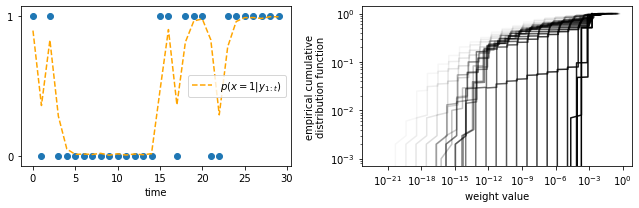

In [17]:
# make fancy plots
times = np.arange(n_observations)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3))
# plot data and time trace of one of the posterior probabilities
ax1.scatter(times, observations)
ax1.plot(times, target_samples.sum(1) / n_samples,
         ls='--', color='orange', label=r'$p(x=1|y_{1:t})$')
ax1.set_yticks((0, 1))
ax1.set_xlabel("time")
ax1.legend()

# for each time step, plot cumulative distribution of weights
# whose lines get darker with increasing time step
for alpha, weights in zip(np.linspace(1, 0, n_observations),
                          all_weights):
    ax2.plot(np.sort(weights),
             np.linspace(0, 1, n_particles, endpoint=False),
             color="black", alpha=alpha)
# double log scale because the plot sucks otherwise
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("empirical cumulative\ndistribution function")
ax2.set_xlabel("weight value")

fig.tight_layout()
plt.show()


The left plot shows the data together with the posterior probabilities for the hidden state to be $1$. The right plot shows the empirical cumulative distribution function (eCDF) of the weight values for different times. So the $y$-axis shows the fraction of weights which are smaller than a certain value. The more time progresses, the fainter the lines get. They shift towards the left, meaning that more and more weights have values of essentially zero, which nicely illustrates the weight decay.